In [93]:
from cv2 import cv2
import numpy as np
from matplotlib import pyplot as plt
import statistics
import mahotas
import bisect
import imutils

In [94]:
# note class
class Note: 
    def __init__(self, centroid_x, y_dot):
        self.centroid_x = centroid_x
        self.y_dot = y_dot

# just  a function for printing images
def display_img(title, img):
    cv2.imshow(title, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
      
# function for getting next note
def getNextNote(first_note):
    if "#" in first_note: 
        octave = first_note[2]
        if first_note[:2] == "A#":
            return ("C#" + octave)
        elif first_note[:2] == "C#":
            return ("D#" + octave)
        elif first_note[:2] == "D#":
            return ("F#" + octave)
        elif first_note[:2] == "F#":
            return ("G#" + octave)
        elif first_note[:2] == "G#":
            next_octave = int(octave) + 1
            return ("A#" + str(next_octave))
    
    else: 
        octave = first_note[1]
        if first_note[0] == "A":
            return ("B" + octave)
        elif first_note[0] == "B":
            return ("C" + octave)
        elif first_note[0] == "C":
            return ("D" + octave)
        elif first_note[0] == "D":
            return ("E" + octave)
        elif first_note[0] == "E":
            return ("F" + octave)
        elif first_note[0] == "F":
            return ("G" + octave)
        elif first_note[0] == "G":
            next_octave = int(octave) + 1
            return ("A" + str(next_octave))

# function for doing connected components
def connectedComponents(binarized_img, img, display_result, min_area = 100):
    connectivity = 1
    output = cv2.connectedComponentsWithStats(binarized_img, connectivity, cv2.CV_32S)
    num_labels = output[0]
    labels = output[1]
    stats = output[2]
    centroids = output[3]

    final_labels = []

    output = img.copy()

    for i in range(1, num_labels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[i]
        
        if (min_area < area < np.inf):
            final_labels.append([i,cX])
            
            if (display_result):
                cv2.rectangle(output, (x,y), (x+w, y+h), (255,0,0),1)
                cv2.circle(output, (int(cX), int(cY)), 4, (255,255,0), -1)
                componentMask = (labels == i).astype("uint8") * 255
                cv2.imshow("Output", output)
                cv2.waitKey(0)

    key_width = statistics.median(stats[:, cv2.CC_STAT_WIDTH])
    cv2.destroyAllWindows()
    return final_labels, key_width


def displayCentroid(key_list, img):
    y = img.shape[0]*3//4
    for (note, centroid) in key_list: 
        font = cv2.FONT_HERSHEY_SIMPLEX
        line = cv2.line(img,(int(centroid),0),(int(centroid),900),(0,0,255),1)
        text_label = cv2.putText(img, note, (int(centroid), y), font, 0.5, (0,255,0), 1)
        cv2.imshow("Key Label", img)
        cv2.waitKey(0)
    cv2.destroyAllWindows()

def key_pressed(key_list, key_index):
    insertion_point = bisect.bisect_left(key_list[:,1].astype(float),key_index)
    
    #Insertion outside our index, means to insert it at the end (return the last key)
    if insertion_point >= len(key_list):
        insertion_point = len(key_list)-1
#     print(insertion_point)
#     print('You pressed the {} key.'.format(key_list[insertion_point,0]))

    note = key_list[insertion_point,0]
    index = insertion_point

    return note, index


## 1. Load image in

Always start at the first frame - before ANY keys are clicked. This is because if a note is coloured on the keys themselves, our thresholding set-up doesn't work.

**There is an issue when people have intros...**

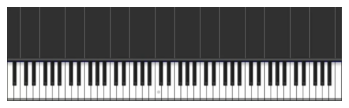

In [95]:
#reading in image
keys = cv2.imread("synthesia.png")
keys = keys[keys.shape[0]//2:,:]

#grayscale
gray_keys = cv2.cvtColor(keys, cv2.COLOR_BGR2GRAY)

################################
################# edge detection
std_dev = 0
k = 5
t1 = 200
t2 = 200
blurred = cv2.GaussianBlur(gray_keys, (k,k), std_dev)
edges = cv2.Canny(blurred, t1,t2, apertureSize = 3)

################################
################# hough transform 
lines = cv2.HoughLines(edges, 1, np.pi/180, 300) 
y_cord = [] #the y-value of the lines generated from hough transform

#iterating through lines
for line in lines: 
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    y_cord.append(y0) #appending to list

#Only want to two lines from hough transform that crops out image of piano
if (len(y_cord) > 2):
    y_cord.sort(reverse=True)
    y_cord.pop()

#crop gray
cropped_keys      = keys[int(y_cord[1])+20:int(y_cord[0])]
cropped_gray_keys = gray_keys[int(y_cord[1])+20:int(y_cord[0])]

################################
################# thresholding
_, th1 = cv2.threshold(cropped_gray_keys, 90, 150, cv2.THRESH_BINARY_INV)

plt.imshow(keys)
plt.axis('off')
plt.show()

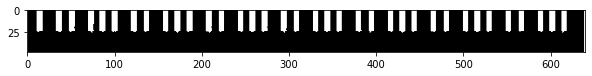

In [96]:
plt.figure(figsize=(10,10))
plt.imshow(th1, cmap = "gray")
plt.show()

# 2. Label Black Keys
We don't need to do distance math anymore. If we detect 36 black keys, we know that the first black key is A#.

*final_labels* is the 36 integer indices that tell us if the returned centroids are black keys. 

For example, if centroids returns 39 possible connected components, final_label is the list of 36 indices that we consider are black keys.

## 1.1 Get the average width of a black key
### Also get all balck key info (centroid etc)
This will be used to determine the discrete range of each key.

In [97]:
################################
################# Connected Components (for black keys)
#SWITCH TRUE TO FALSE IF YOU DONT WANT TO SHOW OUTPUT
final_labels_bl, key_width_bl = connectedComponents(th1, cropped_keys, False)

In [98]:
################################
################# Labelling (for black keys)
if len(final_labels_bl) == 36: 
    first_note = "A#0"
    for i in range(36):
        final_labels_bl[i][0] = first_note
        first_note = getNextNote(first_note)

final_labels_bl = sorted(final_labels_bl, key=lambda x: x[1])

#just displaying to test
# displayCentroid(final_labels_bl, keys)

# 2. Label White Keys
Testing white keys

In [99]:
################################
################# Connected Components (for white keys)
k = 7
blurred = cv2.GaussianBlur(cropped_gray_keys, (k,k), 0)
T = mahotas.thresholding.otsu(blurred)*1.3
th2 = cropped_gray_keys.copy()
th2[th2>T] = 255
th2[th2<T] = 0
final_labels_w, key_width_w = connectedComponents(th2, cropped_keys, False)

In [100]:
################################
################# Labelling (for white keys)
if len(final_labels_w) == 52: 
    first_note = "A0"
    for i in range(52):
        final_labels_w[i][0] = first_note
        first_note = getNextNote(first_note)

final_labels_w = sorted(final_labels_w, key=lambda x: x[1])

#just displaying to test
# displayCentroid(final_labels_w, keys)

# 3. Assign Ranges
Order both the white and black keys together. 

For the range x:0 -> end, we assign a specify range to each key. For example, A: 0 - 10, A#: 10 - 15.

Our assumption is that the centroid of the key played will land in a discrete range with no overlap/ambiguity.

In [101]:
################################
################# Assign ranges
full_key_list = final_labels_bl + final_labels_w
full_key_list = sorted(full_key_list, key=lambda x: x[1].astype(float))
# for ls in full_key_list: 
#     ls = ls.reverse()
full_key_list = np.array(full_key_list)
# print(full_key_list)

The code below maps the actual range for each discrete key.

We know that black keys are skinnier than white keys, and we took the median width of the black keys above. For each black key, it's range is ***centroid - black_key_width/2 < x < centroid + black_key_width/2***.

For white keys adjacent to black keys, the above axiom provides one of the bounds.

For white keys adjacent to white keys, we simply take the mid-way point between their centroids as one of the bounds.

In [102]:
test_list = np.empty([len(full_key_list), 2], dtype='object')

for i in range(0,len(full_key_list)-1):
    if len(full_key_list[i,0])==1 and len(full_key_list[i+1,0])>1: # White adjacent to black
        test_list[i,1] = full_key_list[i+1,1].astype(float) - key_width_bl/2
    elif len(full_key_list[i,0])>1: # Black key
        test_list[i,1] = full_key_list[i,1].astype(float) + key_width_bl/2
    else: # White key adjacent to white key
        test_list[i,1] = (full_key_list[i,1].astype(float)+full_key_list[i+1,1].astype(float))/2
    
    # No change to the actual note (only the distances, above)
    test_list[i,0] = full_key_list[i,0]

#For the last key, just take it to infinity
test_list[-1,1] = np.inf
test_list[-1,0] = full_key_list[-1,0]

full_key_list = test_list
#print(full_key_list)

The function below **inserts** any given value between our established key ranges. It returns an index where the given value *would* be inserted, which gives us our corresponding key pressed.

In [103]:
note, index = key_pressed(full_key_list, 999)
# print(index)

# 4. Testing with Notes

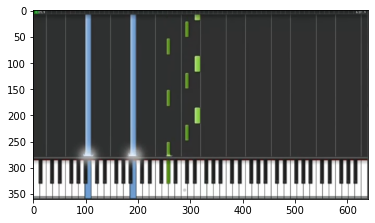

In [119]:
#sample piano image from youtube
img_notes = cv2.imread("Moonlight Sonata 1st Movement_02.png")

#converting to gray
gray_notes = cv2.cvtColor(img_notes, cv2.COLOR_BGR2GRAY)
img_notes_rgb = cv2.cvtColor(img_notes, cv2.COLOR_BGR2RGB)

plt.imshow(img_notes_rgb)
# plt.axis('off')
plt.show()

*y_cord[1]* is the position of the top of the keyboard. We calculated this using **half** the original image, so we need to add this back in.

# I added it back paps =3

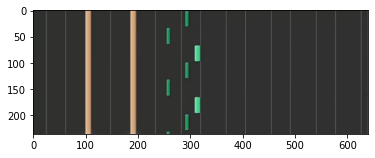

In [120]:
#Cropped
top_keys_index = y_cord[1] + img_notes.shape[0]//2
crop_img_notes = img_notes[20:(int(top_keys_index)-30)] #Crop the top 20 pixels and bottom 30

plt.imshow(crop_img_notes)

Identify notes.

In [124]:
crop_img_notes_gray = cv2.cvtColor(crop_img_notes, cv2.COLOR_BGR2GRAY)
# # k = 3
# # blurred = cv2.GaussianBlur(crop_img_notes_gray, (k,k), 0)

# #Using standard threshold to create contrast between white/black keys
# _, th_notes = cv2.threshold(blurred, 90, 150, cv2.THRESH_BINARY)

# _, th_notes = cv2.threshold(crop_img_notes_gray, 90, 150, cv2.THRESH_BINARY)

# plt.figure(figsize=(10,10))
# plt.imshow(th_notes, cmap = "gray")
# plt.show()

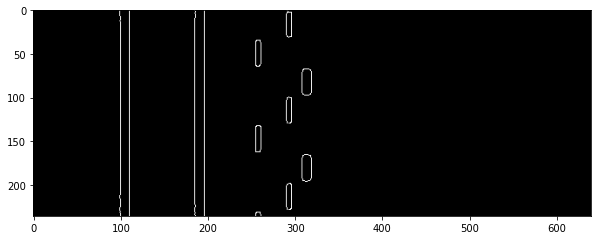

In [163]:
k = 7 #This level of blurring made it possible to just view the notes
blurred = cv2.GaussianBlur(crop_img_notes_gray, (k,k), 0)

t1 = 15
t2 = 105
edged = cv2.Canny(blurred, t1, t2)

plt.figure(figsize=(10,10))
plt.imshow(edged, cmap = "gray")

# Iterating on Contours
If we have a rectangle that spans the whole screen - the caps are not detected. We need to create our **own** caps.

# of notes: 12


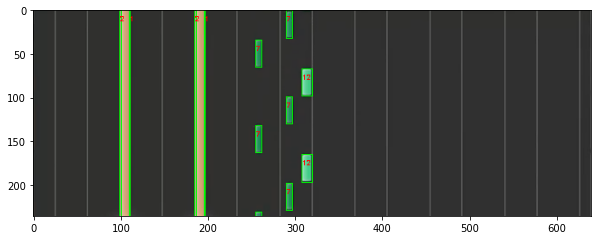

In [192]:
#Count notes
(cnts, _) = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)

#Each list within cnts is the list of contour points - 1 for each coin (total = 9)
print("# of notes: {}".format(len(cnts)))

#Do it on a copy
tmp = crop_img_notes.copy()


problem = []
i = 0
for cnt in cnts:
    
    x,y,w,h = cv2.boundingRect(cnt)
    cv2.rectangle(tmp,(x,y),(x+w,y+h),(0,255,0),1)
    cv2.putText(tmp, str(w), (int(x), int(y+12)), font, 0.25, (255,0,0), 1)
    
    if w < 3:
        problem.append(cnt)
    
    i+=1
    
plt.figure(figsize = (10,10))
plt.imshow(tmp)

For the contours with a width < 3 (?). We extract and figure out what's going on.

In [253]:
flat_list = [item for sublist in problem[3] for item in sublist]
flat_list = [item for sublist in flat_list for item in sublist]
flat_list[::2]

[99,
 99,
 100,
 100,
 99,
 100,
 100,
 99,
 99,
 100,
 100,
 99,
 99,
 100,
 99,
 100,
 100,
 100,
 99,
 100,
 99,
 99,
 100,
 100,
 99,
 99,
 100,
 100,
 99,
 100,
 100,
 99]

In [254]:
#Check if we have a PAIR - otherwise we can't match

problem_x_indx = []
if len(problem) %2 == 0:
    for prblm in problem:
        flat_list = [item for sublist in prblm for item in sublist] # First level of flattening
        flat_list = [item for sublist in flat_list for item in sublist] # Flattens x and y into 1-D vector
        x_indices = flat_list[::2] # Every other element
        print(min(x_indices))

196
185
110
99


In [255]:
edged[1,99:110] = 255
edged[-2, 185:196] = 255

# Key Detection

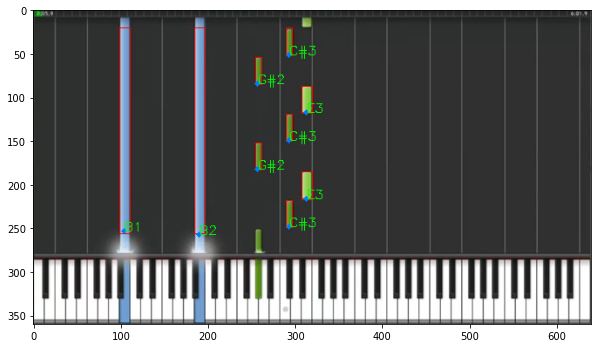

In [256]:
#####################################################################################
####### using connected component detection algorithm to separate all the black notes
connectivity = 8
output = cv2.connectedComponentsWithStats(edged, connectivity, cv2.CV_32S)
num_labels = output[0]
labels = output[1]
stats = output[2]
centroids = output[3]

final_labels = []
note_list = [] #creating a list of all the relavent notes. 


output = img_notes_rgb.copy()
font = cv2.FONT_HERSHEY_SIMPLEX

#For loop only used for displaying 
for i in range(1, num_labels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP] + 20 # We cropped out the first 20 pixels
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[i]
    cY = cY + 20 # We cropped out the first 20 pixels
    if (20 < area < np.inf): #filtering out relavent detections (the ones big enough to be black keys)
        final_labels.append(i)
        cv2.rectangle(output, (x,y), (x+w, y+h), (255,0,0),1)
        dist_to_edge = h/2 #getting the distance from centroid to bottom edge for better detection later on
        cv2.circle(output, (int(cX), int(cY+dist_to_edge)), 1, (0,122,255), 3)
        componentMask = (labels == i).astype("uint8") * 255
        
        note = Note(cX, cY+dist_to_edge) #creating note object and adding to list
        note_list.append(note)
        
        note_played, _ = key_pressed(full_key_list, note.centroid_x)
        cv2.putText(output, note_played, (int(note.centroid_x), int(note.y_dot)), font, 0.5, (0,255,0), 1)

#         display_img("Output", output)
#         display_img("Connected Component", componentMask)
#         cv2.waitKey(0)

# print(final_labels)
# cv2.destroyAllWindows()
plt.figure(figsize=(10,10))
plt.imshow(output)
plt.show()



In [111]:
# # camera = cv2.VideoCapture('Nocturne Opus 9 No 2_trim.mp4')
# # camera = cv2.VideoCapture('Nocturne Opus 9 No 2.mp4')
# camera = cv2.VideoCapture('Moonlight Sonata 1st Movement  Opus 27 No 2.mp4')

# import time


# frames = camera.get(cv2.CAP_PROP_FRAME_COUNT)
# fps = camera.get(cv2.CAP_PROP_FPS)
# seconds_per_frame = fps/frames
# counter = 0

# notes_pressed = []

# keys_timed = []
# for x in full_key_list:
#     keys_timed.append([x[0]])


# keys_timed_update = []
# for x in full_key_list:
#     keys_timed_update.append([x[0]])


# while (camera.isOpened()):
# #     print(counter)
# #     print('-'*100)
    
#     #grabbed is a boolean than tells us if there is a valid frame
#     (grabbed, frame) = camera.read()
    
#     if not grabbed:
#         break

#     counter += seconds_per_frame
        
         
#     frame = imutils.resize(frame,width = keys.shape[1]) #resize or else it won't work
#     #print(frame.shape)
    
#     crop_frame = frame[20:int(top_keys_index)-30] #Crop the top 20 pixels and bottom 30
    

#     #########################################
#     ###### Instead of thresholding, use Canny edge detection
#     crop_frame_gray = cv2.cvtColor(crop_frame, cv2.COLOR_BGR2GRAY)
# #     k = 3
# # #     blurred = cv2.GaussianBlur(crop_frame_gray, (k,k), 0)
# #     blurred = crop_frame_gray #No blur - will cause us to connect notes that shouldn;t be connected
# #     _, th_crop_frame = cv2.threshold(blurred, 90, 150, cv2.THRESH_BINARY)

#     k = 5 #This level of blurring made it possible to just view the notes
#     blurred = cv2.GaussianBlur(crop_frame_gray, (k,k), 0)

#     t1 = 15
#     t2 = 105
#     edged = cv2.Canny(blurred, t1, t2)
    

#     #####################################################################################
#     ####### using connected component detection algorithm to separate all the notes
#     connectivity = 1
#     output = cv2.connectedComponentsWithStats(edged, connectivity, cv2.CV_32S)
# #     output = cv2.connectedComponentsWithStats(th_crop_frame, connectivity, cv2.CV_32S)
#     num_labels = output[0]
#     labels = output[1]
#     stats = output[2]
#     centroids = output[3]

#     font = cv2.FONT_HERSHEY_SIMPLEX
#     output = frame.copy()

#     #For loop only used for displaying 
#     for i in range(1, num_labels):
#         #print(counter)
#         x = stats[i, cv2.CC_STAT_LEFT]
#         y = stats[i, cv2.CC_STAT_TOP] + 20 # We cropped out the first 20 pixels
#         w = stats[i, cv2.CC_STAT_WIDTH]
#         h = stats[i, cv2.CC_STAT_HEIGHT]
#         area = stats[i, cv2.CC_STAT_AREA]
#         (cX, cY) = centroids[i]
#         cY = cY + 20 # We cropped out the first 20 pixels
#         if (25 < area < np.inf): #filtering out relavent detections (the ones big enough to be black keys)
#             cv2.rectangle(output, (x,y), (x+w, y+h), (255,0,0),1)
#             dist_to_edge = h/2 #getting the distance from centroid to bottom edge for better detection later on
#             top_dot = cY-dist_to_edge
#             bottom_dot = cY+dist_to_edge
#             cv2.circle(output, (int(cX), int(bottom_dot)), 1, (0,122,255), 3)
#             cv2.circle(output, (int(cX), int(top_dot)), 1, (0,122,255), 3)
            
#             note = Note(cX, cY+dist_to_edge) #creating note object and adding to list
            
            
#             if ( (bottom_dot >= y_cord[0]) and (bottom_dot <= y_cord[0]+3) ):
#                 note_played, index = key_pressed(full_key_list, cX)
# #                 print(str(note_played) + " at " + str(counter))
#                 keys_timed_update[index].append([counter])

#             if ( (top_dot >= y_cord[0]) and (top_dot <= y_cord[0]+3) ):
#                 note_played, index = key_pressed(full_key_list, cX)
#                 keys_timed_update[index].append([counter])
            
#             disp_note, _ = key_pressed(full_key_list, note.centroid_x)
#             cv2.putText(output, disp_note, (int(note.centroid_x), int(note.y_dot)), font, 0.5, (0,0,255), 1)

            
# #     time.sleep(0.05) #to process frames slower

#     #notes_pressed.append([counter, note_played])
#     cv2.line(output, (0,int(y_cord[0]+0)),(keys.shape[1],int(y_cord[0]+0)),(0,0,255), 2)
#     #Show the frame + drawn rectangle
#     cv2.imshow("Video", output)

#     #Can break early by pressing "q"
#     if cv2.waitKey(1) & 0xFF == ord("q"):
#         break
# # print(keys_timed_update)    
# camera.release()
# cv2.destroyAllWindows()